In [1]:
# -*- coding: utf-8 -*-
import numpy as np
from keras.models import load_model
from PIL import Image
import os
import random
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import interpolate
import openpyxl
import time

random.seed(42)
plt.style.use(['science', 'grid', 'no-latex'])  # 启用科学风格
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rc('font', family='Times New Roman')


In [3]:
# quetion 2.1
both = (0.60847819 + 0.44374065 + 0.61928281 + 0.2330617 + 1.52023123) / 5
rotate = (0.55916994 + 0.71266359 + 0.63397556 + 0.46285008 + 1.40474388) / 5
flipping = (1.09161492 + 0.33113010 + 1.05975352 + 0.37661017 + 1.90429778) / 5
neither = (0.73714691 + 0.30922598 + 0.56940204 + 0.28375992 + 4.56394135) / 5
print("in original test, both:{}, rotate:{}, flipping:{}, neither:{}".format(both, rotate, flipping, neither))


both = (1.24368897 + 1.19082498 + 1.36432628 + 1.3724841 + 3.3348852) / 5
rotate = (1.18564008 + 1.28830863 + 1.31178919 + 1.4818635 + 3.45269949) / 5
flipping = (2.01524496 + 1.24469714 + 2.09770827 + 1.72732041 + 4.35337071) / 5
neither = (5.02860929 + 2.34468264 + 5.38124013 + 3.89984033 + 9.15889678) / 5
print("in agumented test, both:{}, rotate:{}, flipping:{}, neither:{}".format(both, rotate, flipping, neither))

in original test, both:0.684958916, rotate:0.75468061, flipping:0.9526812980000001, neither:1.29269524
in agumented test, both:1.701241906, rotate:1.7440601780000002, flipping:2.287668298, neither:5.162653833999999


In [4]:
# 数据预处理
def process(train_y):
    print('process data\n')  # 服务器进度展示

    # y归一化到[0,1]
    train_max = np.max(train_y, axis=0)
    train_min = np.min(train_y, axis=0)
    for i in range(train_y.shape[1]):
        train_y[:, i] = (train_y[:, i] - train_min[i]) / (train_max[i] - train_min[i])

    return train_y


def load_data():
    print('load  data')
    ## 载入测试集的x
    count = -1
    final_test_data = np.zeros([344, 64, 64, 64, 1])
    for cycleTiff in range(357):
        filename = "/home/guozy/Ni-YSZ_CNN/predict/anode_stacks_15000/" + str(cycleTiff + 1) + ".tiff"
        if os.path.exists(filename) == False:
            continue
        count = count + 1
        img = Image.open(filename)
        for i in range(img.n_frames):  # 可以用img.n_frames来得到总页数
            try:
                img.seek(i)  # 是否存在
                final_test_data[count, :, :, i, 0] = img
            except EOFError:  # 页数读完了
                break

    # 载入测试集的y
    with open("/home/guozy/Ni-YSZ_CNN/predict/Results_15000_predict.txt", "r") as f:
        line = f.readline()
        label_list = []
        while line:
            num = list(map(float, line.split()))
            label_list.append(num)
            line = f.readline()
        f.close()
        final_test_label = np.array(label_list)

    return final_test_data, final_test_label


# 载入选择的模型
def get_model(name=None):
    if name == None:

        print('avaliable model:')
        print('-' * 10)
        filepath = '/home/guozy/Ni-YSZ_CNN/model/'
        subpath = os.listdir(filepath)
        count = -1
        for p in subpath:
            count += 1
            print('{},{}'.format(count, p))
        print('-' * 10)

        choice = int(input('input the number of the determined model\n'))
        filepath = filepath + subpath[choice] + '/model.h5'
        print('load model')
        model = load_model(filepath, compile=False)  # 根据具体读取模型地址修改

    else:
        filepath = '/home/guozy/Ni-YSZ_CNN/model/' + name + '/model.h5'
        model = load_model(filepath, compile=False)  # 根据具体读取模型地址修改

    return model

# 载入数据并数据增强
def both(xi,choice):
    x_aug = np.zeros([1, 64, 64, 64, 1])  # 增强后的样本x
    
    # 分12种情况进行讨论
    if choice == 1:  # x轴为对称轴
        for i in range(64):
            x_aug[0, :, :, i, 0] = np.flip(xi[:, :, i, 0], axis=0)

    elif choice == 2: # y轴为对称轴
        for i in range(64):
            x_aug[0, :, :, i, 0] = np.flip(xi[:, :, i, 0], axis=1)

    elif choice == 3: # z轴为对称轴
        for i in range(64):
            x_aug[0, i, :, :, 0] = np.flip(xi[i, :, :, 0], axis=1)
    
    elif choice == 4:
        for i in range(64):
            x_aug[0, i, :, :, 0] = np.rot90(xi[i, :, :, 0], 1)

    elif choice == 5:
        for i in range(64):
            x_aug[0, i, :, :, 0] = np.rot90(xi[i, :, :, 0], 2)

    elif choice == 6:
        for i in range(64):
            x_aug[0, i, :, :, 0] = np.rot90(xi[i, :, :, 0], 3)

    elif choice == 7:
        for i in range(64):
            x_aug[0, :, i, :, 0] = np.rot90(xi[:, i, :, 0], 1)

    elif choice == 8:
        for i in range(64):
            x_aug[0, :, i, :, 0] = np.rot90(xi[:, i, :, 0], 2)

    elif choice == 9:
        for i in range(64):
            x_aug[0, :, i, :, 0] = np.rot90(xi[:, i, :, 0], 3)

    elif choice == 10:
        for i in range(64):
            x_aug[0, :, :, i, 0] = np.rot90(xi[:, :, i, 0], 1)

    elif choice == 11:
        for i in range(64):
            x_aug[0, :, :, i, 0] = np.rot90(xi[:, :, i, 0], 2)

    elif choice == 12:
        for i in range(64):
            x_aug[0, :, :, i, 0] = np.rot90(xi[:, :, i, 0], 3)

    return x_aug # (1, 64, 64, 64, 1)

def aug_data(x, y):
    print('augment data in all ways\n')
    total = x.shape[0]  # 总共有多少幅图
    x_aug = np.zeros([total * 12, 64, 64, 64, 1],dtype=np.float32)  # 增强后的样本x
    y_aug = y

    for i in range(1,13): # 共12种方法
        for j in range(total): # 共total幅图
            xj = x[j, :, :, :, :]  # 得到第i个样本
            x_aug[(i-1) * total + j, :, :, :, :] = both(xj, i)
        y_aug= tf.concat([y_aug, y], axis=0)
    x_aug = tf.concat([x, x_aug], axis=0)

    return x_aug.numpy(), y_aug.numpy()

# 载入数据
# test_x, test_y = load_data()
# test_x, test_y = aug_data(test_x, test_y)



load  data
augment data in all ways



2023-04-18 20:33:34.570102: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 20:33:36.278102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22193 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d5:00.0, compute capability: 8.6
2023-04-18 20:33:36.284411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22301 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:f5:00.0, compute capability: 8.6


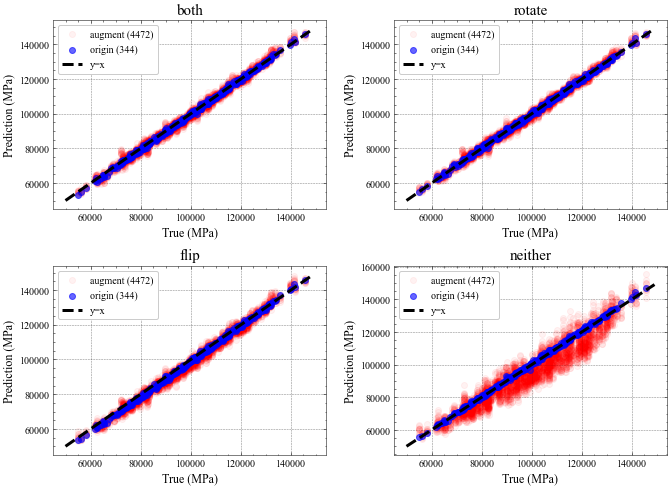

In [9]:
# 画实际-预测散点图
def show_mae_scatter(test_x, test_y):
    max_min_nor = np.array(
        [[1.65219166e+05, 4.88838187e+04], [2.84213381e-01, 2.07984799e-01], [6.37954456e+04, 1.68850886e+04],
         [1.58147200e-05, 1.19209400e-05], [1.34268741e+01, 4.93731340e+00]])

    plt.figure(figsize=(11, 8))
    for i in range(4):
        if i == 0:
            label = "both"
        elif i == 1:
            label = "rotate"
        elif i == 2:
            label = "flip"
        elif i == 3:
            label = "neither"
        model = get_model(label)
        plt.subplot(2, 2, i + 1)

        # 增强数据点的散点图
        pred_y = np.array(model.predict(test_x[344:, :, :, :, :]), dtype='float64')
        pred_y[:, 0] = pred_y[:, 0] * (max_min_nor[0, 0] - max_min_nor[0, 1]) + max_min_nor[0, 1]
        plt.scatter(test_y[344:, 0], pred_y[:, 0], alpha=0.05, c='r',label = 'augment (4472)')

        # 原始数据点的散点图
        pred_y = np.array(model.predict(test_x[0:344, :, :, :, :]), dtype='float64')
        pred_y[:, 0] = pred_y[:, 0] * (max_min_nor[0, 0] - max_min_nor[0, 1]) + max_min_nor[0, 1]
        plt.scatter(test_y[0:344, 0], pred_y[:, 0], alpha=0.6, c='b',label = 'origin (344)')

        # 画直线
        line = range(50000,150000,1000)
        plt.plot(line,line,color = 'k',linestyle='--',linewidth=3,label='y=x')

        plt.title(label,fontsize=15)
        plt.xlabel('True (MPa)',{'size':12})
        plt.ylabel('Prediction (MPa)',{'size':12})
        plt.legend()
        
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.3)
    # plt.suptitle('Scatter Plot of E ranges from 4 types of Train Data to 2 types of Test Data ', fontsize=17, x=0.53, y=0.95)  # 添加标题
    plt.savefig("/home/guozy/Ni-YSZ_CNN/Figure_4.jpg", dpi=500)

show_mae_scatter(test_x, test_y)

In [5]:
# 得到WMAPE分布数据
def gen_wmape_distribution(test_x, test_y):

    wb = openpyxl.Workbook()
    ws = wb.active
    
    max_min_nor = np.array(
        [[1.65219166e+05, 4.88838187e+04], [2.84213381e-01, 2.07984799e-01], [6.37954456e+04, 1.68850886e+04],
         [1.58147200e-05, 1.19209400e-05], [1.34268741e+01, 4.93731340e+00]])

    for i in range(4):
        if i == 0:
            label = "both"
        elif i == 1:
            label = "rotate"
        elif i == 2:
            label = "flip"
        elif i == 3:
            label = "neither"
        model = get_model(label)
        pred_y = np.array(model.predict(test_x), dtype='float64')
        pred_y[:, 0] = pred_y[:, 0] * (max_min_nor[0, 0] - max_min_nor[0, 1]) + max_min_nor[0, 1]
        pred_y_E = pred_y[:,0]
        test_y_E = test_y[:,0]

        wmape = pred_y_E - test_y_E
        wmape = np.abs(wmape)
        wmape = wmape / test_y_E

        ws.cell(row=1, column=i+1).value = label
        for j in range(wmape.shape[0]):
            ws.cell(row=j+2, column=i+1).value = wmape[j]
    
    wb.save("/home/guozy/Ni-YSZ_CNN/wmape_density.xlsx")

gen_wmape_distribution(test_x, test_y)

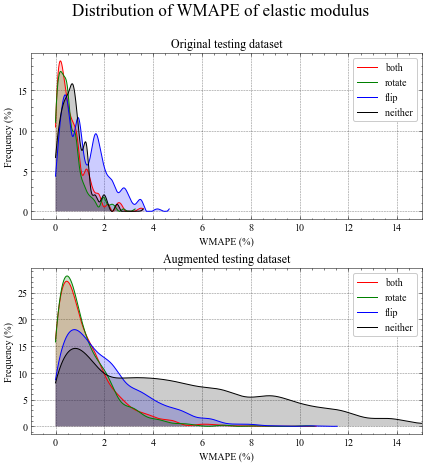

In [14]:
# 画MAPE分布图
def show_wmape_density():

    data = pd.read_excel('/home/guozy/Ni-YSZ_CNN/wmape_density.xlsx',header=0)
    label = ['both', 'rotate', 'flip', 'neither']
    color = ['red','green','blue','k']
    bins_num = 21
    
    plt.figure(figsize=(7, 7))
    
    for i in range(1,3): # 两幅图
        plt.subplot(2,1,i)
        for j in range(4): # 每幅图4条曲线
            
            if i ==1 :
                plt.title('Original testing dataset')
                mape = data.iloc[0:344,j] * 100
            else :
                plt.title('Augmented testing dataset')
                mape = data.iloc[:,j] * 100

            mape_max = np.max(mape)
            bins_contain = mape_max/(bins_num-1)
            
            x = np.zeros([bins_num])
            y = np.zeros([bins_num])

            for k in range(bins_num):
                x[k] = k * bins_contain

            for k in range(len(mape)):
                y[int(np.around(mape[k] / bins_contain))] += 1


            f = interpolate.interp1d(x, y, kind="cubic", fill_value="extrapolate")
            
            x_show=np.linspace(0,mape_max,1000)
            # print(np.max(x_show), mape_max)
            y_show = f(x_show)
            y_show = np.maximum(y_show, 0)
            y_show = y_show / mape.shape[0] * 100
            
            plt.plot(x_show,y_show,label=label[j],color=color[j])
            plt.fill_between(x_show, 0, y_show, facecolor=color[j], alpha=0.2)
            plt.xlim([-1,15])
        
        plt.xlabel('WMAPE (%)')
        plt.ylabel('Frequency (%)')
        plt.legend()
        
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    
    plt.suptitle('Distribution of WMAPE of elastic modulus',fontsize=17)
    plt.savefig('/home/guozy/Ni-YSZ_CNN/Figure_'+str(3)+'.jpg',dpi=1000)

show_wmape_density()

flip程序运行时间:11.564505577087402秒
both程序运行时间:11.11879849433899秒
neither程序运行时间:11.491980075836182秒


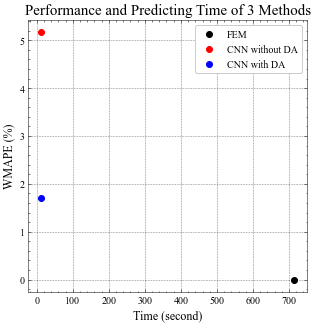

In [7]:
def count_time(test_x, test_y):
    max_min_nor = np.array(
        [[1.65219166e+05, 4.88838187e+04], [2.84213381e-01, 2.07984799e-01], [6.37954456e+04, 1.68850886e+04],
         [1.58147200e-05, 1.19209400e-05], [1.34268741e+01, 4.93731340e+00]])
    
    T1 = time.time()
    model0 = get_model('flip')
    pred0 = np.array(model0.predict(test_x), dtype='float64')
    T2 = time.time()
    both_time = T2 - T1
    print('flip程序运行时间:%s秒' % ((T2 - T1)))


    T1 = time.time()
    model1 = get_model('both')
    pred1 = np.array(model1.predict(test_x), dtype='float64')
    T2 = time.time()
    both_time = T2 - T1
    print('both程序运行时间:%s秒' % ((T2 - T1)))

    T1 = time.time()
    model2 = get_model('neither')
    pred2 = np.array(model2.predict(test_x), dtype='float64')
    T2 = time.time()
    neither_time = T2 - T1
    print('neither程序运行时间:%s秒' % ((T2 - T1)))
    
    # question 2.7
    plt.figure(figsize=(5, 5))
    plt.scatter(715, 0, c='k',label='FEM')
    plt.scatter(neither_time, 5.163, c='r',label='CNN without DA')
    plt.scatter(both_time, 1.701, c='b',label='CNN with DA')

    plt.title('Performance and Predicting Time of 3 Methods',fontsize=15)
    plt.xlabel('Time (second)',{'size':12})
    plt.ylabel('WMAPE (%)',{'size':12})
    plt.legend()

    plt.savefig("/home/guozy/Ni-YSZ_CNN/Figure_8.jpg", dpi=500)

count_time(test_x, test_y)

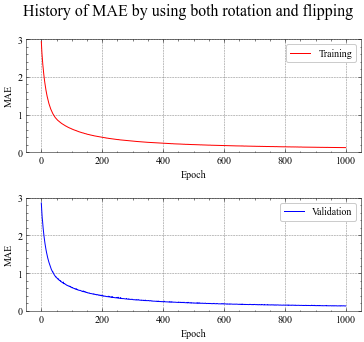

In [2]:
# loss history
train_loss = np.loadtxt("/home/guozy/Ni-YSZ_CNN/model/2023-04-19_21:45:40/TRAIN_loss.txt")
val_loss = np.loadtxt("/home/guozy/Ni-YSZ_CNN/model/2023-04-19_21:45:40/VAL_loss.txt")

plt.figure(figsize=(6, 5))

plt.subplot(2,1,1)
plt.plot(train_loss, c='r', label='Training')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.ylim((0,3))

plt.subplot(2,1,2)
plt.plot(val_loss, c='b', label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.ylim((0,3))

plt.suptitle('History of MAE by using both rotation and flipping',fontsize=16)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
plt.savefig("/home/guozy/Ni-YSZ_CNN/Figure_9.jpg", dpi=500)
plt.show()

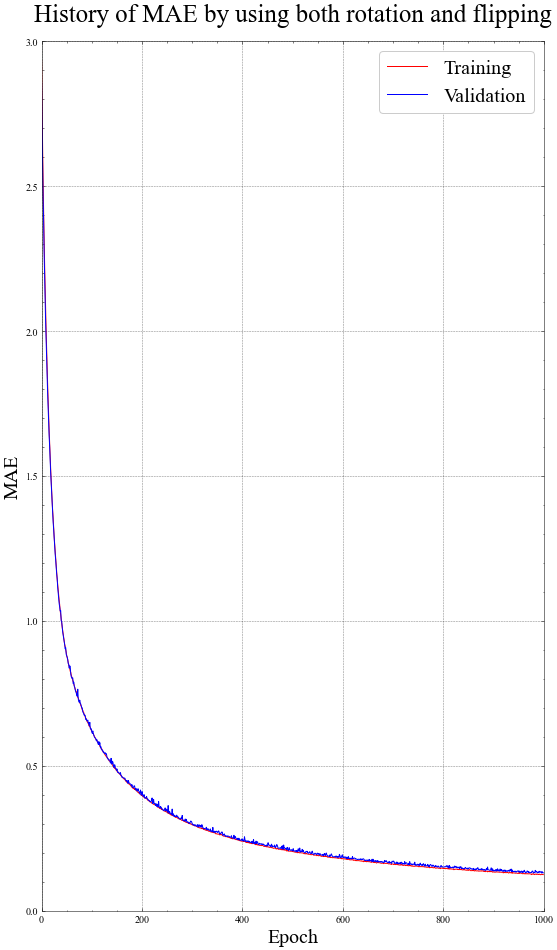

In [24]:
# loss history
train_loss = np.loadtxt("/home/guozy/Ni-YSZ_CNN/model/2023-04-19_21:45:40/TRAIN_loss.txt")
val_loss = np.loadtxt("/home/guozy/Ni-YSZ_CNN/model/2023-04-19_21:45:40/VAL_loss.txt")

plt.figure(figsize=(9, 16))

plt.plot(train_loss, c='r', label='Training')
plt.plot(val_loss, c='b', label='Validation')

plt.legend(fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('MAE',fontsize=20)
plt.ylim((0,3))
plt.xlim((0,1000))

plt.title('History of MAE by using both rotation and flipping',fontsize=25, pad=20)
plt.savefig("/home/guozy/Ni-YSZ_CNN/Figure_9.jpg", dpi=500)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

# 数据预处理
def process(train_x, train_y):
    print('process data\n')

    # y归一化到[0,1]
    train_max = np.max(train_y, axis=0)
    train_min = np.min(train_y, axis=0)
    for i in range(train_y.shape[1]):
        train_y[:, i] = (train_y[:, i] - train_min[i]) / (train_max[i] - train_min[i])

    return train_x, train_y


# 载入训练集
def load_train_data():
    print('load data\n')  # 服务器进度展示

    # 载入训练集的x
    tiff_num = [5000, 10000, 20000, 30000]  # 4个文件夹的名字
    count = -1  # 用来记录打开了第几个样本了
    train_x = np.zeros([1347, 64, 64, 64, 1])  # 训练集的x
    for cycleT in range(4):
        for cycleTiff in range(357):
            filename = "/home/guozy/Ni-YSZ_CNN/train/anode_stacks_" + str(tiff_num[cycleT]) + '/' + str(
                cycleTiff + 1) + ".tiff"
            if os.path.exists(filename) == False:  # 找不到就跳过，因为文件里有一些名字带no
                continue
            count = count + 1
            img = Image.open(filename)
            for i in range(img.n_frames):  # 可以用img.n_frames来得到总页数
                try:
                    img.seek(i)  # 是否存在
                    train_x[count, :, :, i, 0] = img
                except EOFError:  # 页数读完了
                    break

    # 再载入训练集的y
    with open("/home/guozy/Ni-YSZ_CNN/train/Results_all.txt", "r") as f:
        line = f.readline()
        label_list = []
        while line:
            num = list(map(float, line.split()))
            label_list.append(num)
            line = f.readline()
        f.close()
        train_y = np.array(label_list)


    print('training x shape: ', train_x.shape)
    print('training y shape: ', train_y.shape)
    print('\n')

    return train_x, train_y


# 载入选择的模型
def get_model(name=None):
    if name == None:

        print('avaliable model:')
        print('-' * 10)
        filepath = '/home/guozy/Ni-YSZ_CNN/model/'
        subpath = os.listdir(filepath)
        count = -1
        for p in subpath:
            count += 1
            print('{},{}'.format(count, p))
        print('-' * 10)

        choice = int(input('input the number of the determined model\n'))
        filepath = filepath + subpath[choice] + '/model.h5'
        print('load model')
        model = load_model(filepath, compile=False)  # 根据具体读取模型地址修改

    else:
        filepath = '/home/guozy/Ni-YSZ_CNN/model/' + name + '/model.h5'
        model = load_model(filepath, compile=False)  # 根据具体读取模型地址修改

    return model


# 数据增强中的图像旋转
def rotate(xi, choice):
    x_aug = np.zeros([1, 64, 64, 64, 1])  # 增强后的样本x

    # 分9种情况进行讨论
    if choice == 1:
        for i in range(64):
            x_aug[0, i, :, :, 0] = np.rot90(xi[i, :, :], 1)

    elif choice == 2:
        for i in range(64):
            x_aug[0, i, :, :, 0] = np.rot90(xi[i, :, :], 2)

    elif choice == 3:
        for i in range(64):
            x_aug[0, i, :, :, 0] = np.rot90(xi[i, :, :], 3)

    elif choice == 4:
        for i in range(64):
            x_aug[0, :, i, :, 0] = np.rot90(xi[:, i, :], 1)

    elif choice == 5:
        for i in range(64):
            x_aug[0, :, i, :, 0] = np.rot90(xi[:, i, :], 2)

    elif choice == 6:
        for i in range(64):
            x_aug[0, :, i, :, 0] = np.rot90(xi[:, i, :], 3)

    elif choice == 7:
        for i in range(64):
            x_aug[0, :, :, i, 0] = np.rot90(xi[:, :, i], 1)

    elif choice == 8:
        for i in range(64):
            x_aug[0, :, :, i, 0] = np.rot90(xi[:, :, i], 2)

    elif choice == 9:
        for i in range(64):
            x_aug[0, :, :, i, 0] = np.rot90(xi[:, :, i], 3)

    return x_aug


# 镜像
def mirror(xi,choice):
    choice -= 9  # 选择镜像的面
    x_aug = np.zeros([1, 64, 64, 64, 1])  # 增强后的样本x

    # 分9种情况进行讨论
    if choice == 1 or choice == 5:  # x轴为对称轴
        for i in range(64):
            x_aug[0, :, :, i, 0] = np.flip(xi[:, :, i], axis=0)

    elif choice == 2 or choice == 3: # y轴为对称轴
        for i in range(64):
            x_aug[0, :, :, i, 0] = np.flip(xi[:, :, i], axis=1)

    elif choice == 4 or choice == 6: # z轴为对称轴
        for i in range(64):
            x_aug[0, i, :, :, 0] = np.flip(xi[i, :, :], axis=1)

    return x_aug


# 训练集数据增强
def aug_train_data(x, y, label):
    print('augment data\n')
    total = x.shape[0]  # 总共有多少幅图

    for i in range(total):
        xi = x[i, :, :, :, 0]  # 得到第i个样本

        if label == 'both':
            choice =  random.randint(1,15) # 选择：翻转/镜像
        elif label == 'rotate':
            choice =  random.randint(1,9) # 选择：翻转/镜像
        elif label == 'flip':
            choice =  random.randint(10,15) # 选择：翻转/镜像
        elif label =='neither':
            choice =  0 # 选择：翻转/镜像

        if choice >=1 and choice <= 9:
            x_aug = rotate(xi, choice)  
        elif choice >=10 and choice <= 15:
            x_aug = mirror(xi, choice)
        else:
            x_aug = np.zeros([1, 64, 64, 64, 1])  # 增强后的样本x
            x_aug[0, :, :, :, 0]= xi[:, :, :]
        # 将数据增强后的样本和原来的样本合并
        x = tf.concat([x, x_aug], axis=0)

    y = tf.concat([y, y], axis=0)

    return x.numpy(), y.numpy()


def show_wampe(test_x, test_y, label):
    
    my_wampe = np.zeros([5])

    max_min_nor = np.array(
        [[1.65219166e+05, 4.88838187e+04], [2.84213381e-01, 2.07984799e-01], [6.37954456e+04, 1.68850886e+04],
         [1.58147200e-05, 1.19209400e-05], [1.34268741e+01, 4.93731340e+00]])

    model = get_model(label)
    pred_y = np.array(model.predict(test_x))

    for j in range(5):
        pred = pred_y[:, j] * (max_min_nor[j, 0] - max_min_nor[j, 1]) + max_min_nor[j, 1]
        my_wampe[j] = np.sum(np.abs(pred - test_y[:, j])) * 100 / np.sum(np.abs(test_y[:, j]))

    print(label)
    for i in range(5):
        print(i + 1,my_wampe[i])
    print( '\n')

    return my_wampe


def wmape_on_train():
    
    # 数据相关
    train_x, train_y = load_train_data()  # 载入训练集和数据集的数据
    # 划分测试集和验证集
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y,test_size=0.1,random_state=42)
    # 数据增强

    for i in range(4):
        random.seed(43)
        if i == 0:
            label = "both"
        elif i == 1:
            label = "rotate"
        elif i == 2:
            label = "flip"
        elif i == 3:
            label = "neither"
        aug_x, aug_y = aug_train_data(train_x, train_y, label)  # 做训练集数据增强
        show_wampe(aug_x, aug_y, label)


wmape_on_train()

load data

training x shape:  (1347, 64, 64, 64, 1)
training y shape:  (1347, 5)


augment data

both
1 0.9112949555424324
2 0.8043922348361873
3 0.9147697652476829
4 0.8073809295896228
5 2.4013531046870553


augment data

rotate
1 0.9386621704945444
2 1.0127430334677567
3 1.0017814592890002
4 1.0059254854965878
5 2.295903496809008


augment data

flip
1 1.2564196810554173
2 0.47272355117231385
3 1.1969406993036658
4 0.6410663741862977
5 2.1633693000560954


augment data

neither
1 0.6000239937449771
2 0.23278608723716737
3 0.48984615316175006
4 0.29032111030736224
5 4.107633941843072


